In [1]:
import numpy as np
import cv2
import pims
from tqdm.notebook import trange
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# CONSTANTS
# network input resolution
W = 320
H = 160

# annotations' resolution
annot_W = 480
annot_H = 320

In [3]:
# DATA FUNCTIONS
from os import listdir

# get polylines from file
def extract_polylines(filename):
  tree = ET.parse(filename)
  polylines = []
  for polyline in tree.iter(tag='polyline'):
    frame = polyline.get("frame")
    points = polyline.get("points").split(";")
    for i in range(len(points)):
      points[i] = points[i].split(",")
      for j in range(len(points[i])):
        points[i][j] = float(points[i][j])
    data = (int(frame), points)
    polylines.append(data)

  return sorted(polylines)

# get polylines from each frame
def extract_frame_lines(polylines):
  n_frames = polylines[-1][0]
  frames = []

  for i in range(n_frames+1):
    frame = []
    for polyline in polylines:
      if polyline[0] == i:
        frame.append(polyline[1])
    frames.append(sorted(frame))
    
  return frames

# convert annotations to new resolution
def convert_annotations(old_res, new_res, annotations):
  W, H = old_res
  new_W, new_H = new_res
  new_annotations = []
  for polylines in annotations:
    new_polylines = []
    for polyline in polylines:
      new_polyline = []
      for point in polyline:
        x, y = point
        new_x = (x*new_W) / W
        new_y = (y*new_H) / H
        new_polyline.append([new_x,new_y])
      new_polylines.append(new_polyline)
    new_annotations.append(new_polylines)
  return np.array(new_annotations)

# get training data from path
def get_data(video_path, annotations_path):
  # get video frames
  frames = pims.Video(video_path, format="mp4")
  
  # get road edges data
  annotations = extract_polylines(annotations_path)
  annotations = extract_frame_lines(annotations)
  annotations = convert_annotations((annot_W,annot_H), (W,H), annotations)

  return frames, annotations

# make pims video into actual numpy frames
def conv_frames(frames):
  imgs = []
  print("Getting frames into proper arrays")
  for frame in frames:
    imgs.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (W,H)))
  print("Frames converted to numpy arrays")
  return np.array(imgs)

base_dir = "../data/videos/usable/"
video_files = []
annot_files = []
for f in listdir(base_dir):
  if f.endswith(".mp4"):
    video_files.append(f)
  elif f.endswith(".xml"):
    annot_files.append(f)
video_files, annot_files = sorted(video_files), sorted(annot_files)

video_files = video_files[:3] # TODO: this is a temp hack, need to get all videos' annotations
print(video_files)
print(annot_files)

assert len(video_files) == len(annot_files), "Number of video files != number of annotation files"

['city_1.mp4', 'city_2.mp4', 'city_3.mp4']
['city_1_annotations.xml', 'city_2_annotations.xml', 'city_3_annotations.xml']


In [4]:
# ANNOTATIONS TRANSFORMATIONS

# TODO: this algorithm has bad complexity (O(n^3)), refactor if possible
# convert polylines per frame to net output vector (flattens the array)
def serialize_polylines(polylines, n_coords, n_points, max_n_lines):
  # check if we have more than n_points
  # TODO: instead of removing the whole line, just get polyline[:n_points]
  for polyline in polylines.copy():
    if len(polyline) != n_points:
      polylines.remove(polyline)
  assert len(polylines) <= max_n_lines, "More than max number of lines found"

  # fill the gaps with negative values (-1 or -10 or -100 == NULL => out of bounds)
  if len(polylines) < max_n_lines:
    for i in range(max_n_lines - len(polylines)):
      new_polyline = []
      for j in range(n_points):
        point = []
        for k in range(n_coords):
          point.append(-100.)
        new_polyline.append(point)
      polylines.append(new_polyline)
      
  # flatten
  ret = []
  for i in range(max_n_lines):
    for j in range(n_points):
      for k in range(n_coords):
        ret.append(polylines[i][j][k])

  return np.array(ret)

# TODO: this needs more work depending on the net output, since it is tested only on annotations
# convert network output vector to polylines per frame
def deserialize_polylines(net_output, n_coords, n_points, max_n_lines):
  polylines = []
  point = []
  line = []
  for i in range(len(net_output)):
    point.append(net_output[i])
    if len(point) == 2:
      line.append(point)
      point = []
    if len(line) == 4:
      polylines.append(line)
      line = []

  # remove (-1, -1)/out-of-bounds points from lines
  for polyline in polylines:
    while [-100., -100.] in polyline:
      #polyline.remove([-100., -100.]) # TODO: remove all negative numbers, not just (-1., -1.) pairs
      polyline.remove([-100., -100.])

  # remove empty lists
  while [] in polylines:
    polylines.remove([])

  return np.array(polylines)

In [ ]:
# test the above functions (this will be later used on the training loop for Y_train)
n_coords = 2  # 2 coordinates: x,y
n_points = 4  # number of points of each polyline
max_n_lines = 6 # max number of polylines per frame

frames, annotations = get_data(base_dir+video_files[2], base_dir+annot_files[2])

idx = 0
for polylines in annotations:
  ret = serialize_polylines(polylines, n_coords, n_points, max_n_lines)
  print("++++++++++")
  print("Frame", idx)
  print(ret)
  print("==========")
  new_polylines = deserialize_polylines(ret, n_coords, n_points, max_n_lines)
  print(new_polylines)
  idx += 1

In [ ]:
# OLD TESTS

# model for road edge detection
class REDetector(nn.Module):
  def __init__(self):
    super(REDetector, self).__init__()

    # output polylines attributes
    self.n_coords = 2  # 2 coordinates: x,y
    self.n_points = 4  # number of points of each polyline
    self.max_n_lines = 6 # max number of polylines per frame

    # Convolutional Layers 
    # NOTE: in order to multitask-learn with CRDetector (conv layers will be the same since they sohould detect the same features), this part should not be changed
    # TODO: change this architecture (ResNet)
    """
    # old AlexNet architecture
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2d_bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv2d_bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv2d_bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, 3)
    self.conv2d_bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128, 256, 3)
    self.conv2d_bn5 = nn.BatchNorm2d(256)
    """
    # TODO: ELU activations for these and MaxPool before fully connected layers
    # plain block 1 at the start
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.avg_pool = nn.AvgPool2d(3, 2)

    # TODO: maybe use a _make_layer function from https://jarvislabs.ai/blogs/resnet
    # residual blocks (convolutions on identity blocks are for matching the dimensions on the addition)
    # block 2
    self.conv2 = nn.Conv2d(16, 16, 1)
    self.bn2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16, 16, 5)
    self.bn3 = nn.BatchNorm2d(16)
    self.conv4 = nn.Conv2d(16, 32, 1)
    self.bn4 = nn.BatchNorm2d(32)
    # identity block for 2
    self.conv5 = nn.Conv2d(16, 32, 1)
    self.bn5 = nn.BatchNorm2d(32)

    # block 3
    self.conv6 = nn.Conv2d(32, 32, 1)
    self.bn6 = nn.BatchNorm2d(32)
    self.conv7 = nn.Conv2d(32, 32, 5)
    self.bn7 = nn.BatchNorm2d(32)
    self.conv8 = nn.Conv2d(32, 64, 1)
    self.bn8 = nn.BatchNorm2d(64)
    # identity block for 3
    self.conv9 = nn.Conv2d(32, 64, 1)
    self.bn9 = nn.BatchNorm2d(64)

    # block 4
    self.conv10 = nn.Conv2d(64, 64, 1)
    self.bn10 = nn.BatchNorm2d(64)
    self.conv11 = nn.Conv2d(64, 64, 3)
    self.bn11 = nn.BatchNorm2d(64)
    self.conv12 = nn.Conv2d(64, 128, 1)
    self.bn12 = nn.BatchNorm2d(128)
    # identity block for 4
    self.conv13 = nn.Conv2d(64, 128, 1)
    self.bn13 = nn.BatchNorm2d(128)

    # block 5
    self.conv14 = nn.Conv2d(128, 128, 1)
    self.bn14 = nn.BatchNorm2d(128)
    self.conv15 = nn.Conv2d(128, 128, 3)
    self.bn15 = nn.BatchNorm2d(128)
    self.conv16 = nn.Conv2d(128, 256, 1)
    self.bn16 = nn.BatchNorm2d(256)
    # identity block for 5
    self.conv17 = nn.Conv2d(64, 256, 1)
    self.bn17 = nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(3, 2)

    # TODO: this doesn't fit in RAM (either put less neurons per hidden layer, or less hidden layers)
    # Fully Connected Layers
    #self.dropout1 = nn.Dropout(0.1)
    self.fc1 = nn.Linear(256*2*7, 2048) # for 320x160 image 256 channels
    self.fc_bn1 = nn.BatchNorm1d(2048)
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc_bn4 = nn.BatchNorm1d(128)
    #self.dropout2 = nn.Dropout(0.5)
    self.fc5 = nn.Linear(128, self.n_coords*self.n_points*self.max_n_lines)


  def forward(self, x):
    """
    # old AlexNet architecture
    x = self.pool(F.relu(self.conv2d_bn1(self.conv1(x))))
    x = self.pool(F.relu(self.conv2d_bn2(self.conv2(x))))
    x = self.pool(F.relu(self.conv2d_bn3(self.conv3(x))))
    x = self.pool(F.relu(self.conv2d_bn4(self.conv4(x))))
    x = self.pool(F.relu(self.conv2d_bn5(self.conv5(x))))
    """
    # TODO: need to match the size of out and identity on addition
    # plain block
    out = self.avg_pool(F.elu(self.conv1(x)))
    # block 2
    identity = out
    out = F.elu(self.bn2(self.conv2(out)))
    out = F.elu(self.bn3(self.conv3(out)))
    out = self.bn4(self.conv4(out))
    identity = self.bn5(self.conv5(identity))
    print(out.shape, identity.shape)
    out += identity

    # block 3
    identity = out
    out = F.elu(self.bn6(self.conv6(out)))
    out = F.elu(self.bn7(self.conv7(out)))
    out = self.bn8(self.conv8(out))
    identity = self.bn9(self.conv9(identity))
    out += identity

    # block 4
    identity = out
    out = F.elu(self.bn10(self.conv10(out)))
    out = F.elu(self.bn11(self.conv11(out)))
    out = self.bn12(self.conv12(out))
    identity = self.bn13(self.conv13(identity))
    out += identity

    # block 5
    identity = out
    out = F.elu(self.bn14(self.conv14(out)))
    out = F.elu(self.bn15(self.conv15(out)))
    out = self.bn16(self.conv16(out))
    identity = self.bn17(self.conv17(identity))
    out += identity
    out = self.max_pool(out)

    print(out.shape)
    # TODO: relu doesnt allow negative values, try to mix it up with tanh (first or last FC layers) as well as relu
    # USE ELU(-1. for ground-truth)/LEAKY_ELU(-100. for ground-truth) FOR FC and RESNET (5 blocks) FOR CONV
    out = x.view(-1, self.num_flat_features(out))
    out = self.dropout1(out)
    out = F.leaky_relu(self.fc_bn1(self.fc1(out)))
    out = F.leaky_relu(self.fc2(out))
    out = F.leaky_relu(self.fc3(out))
    out = F.leaky_relu(self.fc_bn4(self.fc4(out)))
    #x = self.dropout2(x)
    out = self.fc5(out)
    return out

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [5]:
# PYTOCH MODEL

# ResNet block
class ResBlock(nn.Module):
  def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
    super(ResBlock, self).__init__()

    self.num_layers = num_layers
    if self.num_layers > 34:
      self.expansion = 4
    else:
      self.expansion =1

    # ResNet50, 101 and 152 include additional layer of 1x1 kernels
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    if self.num_layers > 34:
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    else:
      # for ResNet18 and 34, connect input directly to 3x3 kernel (skip first 1x1)
      self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.elu = nn.ELU()
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x
    if self.num_layers > 34:
      x = self.elu(self.bn1(self.conv1(x)))
    x = self.elu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))
    
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    x += identity
    x = self.elu(x)
    return x

# model for road edge detection
@variational_estimator
class ResREDetector(nn.Module):
  def __init__(self, num_layers, block, image_channels):
    assert num_layers in [18, 34, 50, 101, 152], "Unknown ResNet architecture, number of layers must be 18, 34, 50, 101 or 152"
    super(ResREDetector, self).__init__()

    # for output layer (polylines shape)
    self.n_coords = 2  # 2 coordinates: x,y
    self.n_points = 4  # number of points of each polyline
    self.max_n_lines = 6 # max number of polylines per frame

    if num_layers < 50:
      self.expansion = 1
    else:
      self.expansion = 4
    if num_layers == 18:
      layers = [2, 2, 2, 2]
    elif num_layers == 34 or num_layers == 50:
      layers = [3, 4, 23, 3]
    elif num_layers == 101:
      layers = [3, 8, 23, 3]
    else:
      layers = [3, 8, 36, 3]

    self.in_channels = 16
    self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=7, stride=2, padding=3)  # TODO: maybe kernel 5x5
    self.bn1 = nn.BatchNorm2d(16)
    self.elu = nn.ELU()
    self.avgpool1 = nn.AvgPool2d(3, 2, padding=1)

    # ResNet Layers
    self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
    self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
    self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
    self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

    self.avgpool2 = nn.AvgPool2d(1, 1)

    # TODO: try 2 layers before changing the loss function, or all batch normalized or more layers (maybe 2 more)
    # Fully Connected Layers
    self.fc1 = nn.Linear(512*5*10, 2048) # NOTE: this works only with ResNet18
    #self.fc1 = nn.Linear(256*self.expansion, 2048)
    self.fc_bn1 = nn.BatchNorm1d(2048)

    # Bayesian Layers
    self.blinear1 = BayesianLinear(2048, 512)
    self.b_bn1 = nn.BatchNorm1d(512)
    self.blinear2 = BayesianLinear(512, 128)
    self.b_bn2 = nn.BatchNorm1d(128)
    self.blinear3 = BayesianLinear(128, self.n_coords*self.n_points*self.max_n_lines)

    """
    self.fc_bn1 = nn.BatchNorm1d(8192)
    self.fc2 = nn.Linear(8192, 4096)
    self.fc_bn2 = nn.BatchNorm1d(4096)
    self.fc3 = nn.Linear(4096, 2048)
    self.fc_bn3 = nn.BatchNorm1d(2048)
    self.fc4 = nn.Linear(2048, 1024)
    self.fc_bn4 = nn.BatchNorm1d(1024)
    self.fc5 = nn.Linear(1024, 512)
    self.fc_bn5 = nn.BatchNorm1d(512)
    self.fc6 = nn.Linear(512, 256)
    self.fc_bn6 = nn.BatchNorm1d(256)
    self.fc7 = nn.Linear(256, 128)
    self.fc_bn7 = nn.BatchNorm1d(128)
    self.fc8 = nn.Linear(128, 64)
    self.fc_bn8 = nn.BatchNorm1d(64)
    self.fc9 = nn.Linear(64, self.n_coords*self.n_points*self.max_n_lines)
    """


  def forward(self, x):
    x = self.avgpool1(self.elu(self.bn1(self.conv1(x))))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool2(x)
    #print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    """
    x = F.leaky_relu(self.fc_bn1(self.fc1(x)))
    x = F.leaky_relu(self.fc_bn2(self.fc2(x)))
    x = F.leaky_relu(self.fc_bn3(self.fc3(x)))
    x = F.leaky_relu(self.fc_bn4(self.fc4(x)))
    x = F.leaky_relu(self.fc_bn5(self.fc5(x)))
    x = F.leaky_relu(self.fc_bn6(self.fc6(x)))
    x = F.leaky_relu(self.fc_bn7(self.fc7(x)))
    x = F.leaky_relu(self.fc_bn8(self.fc8(x)))
    x = self.fc9(x)
    """
    x = F.relu(self.fc_bn1(self.fc1(x)))
    x = F.relu(self.b_bn1(self.blinear1(x)))
    x = F.relu(self.b_bn2(self.blinear2(x)))
    x = self.blinear3(x)
    return x

  def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
    layers = []
    identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                        nn.BatchNorm2d(intermediate_channels*self.expansion))
    layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
    self.in_channels = intermediate_channels*self.expansion
    for i in range(num_residual_blocks - 1):
      layers.append(block(num_layers, self.in_channels, intermediate_channels))
    return nn.Sequential(*layers)

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [6]:
# CUSTOM LOSSES

# negative log likelihood loss
def neg_log_likelihood(output, target, sigma=1.0):
  dist = torch.distributions.normal.Normal(output, sigma)
  return torch.sum(-dist.log_prob(target))

[~] Cleared cuda cache


  0%|          | 0/3 [00:00<?, ?it/s]

[~] Loading from files: ../data/videos/usable/city_1.mp4 , ../data/videos/usable/city_1_annotations.xml


<ipython-input-3-57a004710d60>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(new_annotations)


Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: ../data/videos/usable/city_2.mp4 , ../data/videos/usable/city_2_annotations.xml
Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: ../data/videos/usable/city_3.mp4 , ../data/videos/usable/city_3_annotations.xml
Getting frames into proper arrays
Frames converted to numpy arrays
[+] Training model ...
[+] Epoch 0 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 1 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 2 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 3 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 4 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 5 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 6 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 7 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 8 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 9 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 10 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 11 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 12 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 13 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 14 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 15 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 16 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 17 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 18 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 19 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 20 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 21 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 22 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 23 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 24 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 25 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 26 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 27 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 28 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 29 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 30 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 31 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 32 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 33 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 34 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 35 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 36 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 37 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 38 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 39 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 40 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 41 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 42 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 43 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 44 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 45 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 46 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 47 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 48 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Epoch 49 / 50


  0%|          | 0/61 [00:00<?, ?it/s]

[+] Trained model on all data files


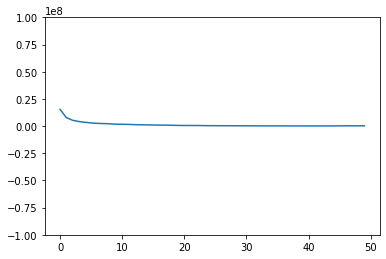

In [7]:
# TRAINING PROCESS
def train(frames, annotations, model):
  #loss_function = nn.L1Loss().to(device) # mean absolute error
  loss_function = nn.MSELoss().to(device) # mean square error
  #loss_function = nn.NLLLoss()  # TODO: NLL for loss (convert to Bayesian Network?), MSE for accuracy

  optim = torch.optim.Adam(model.parameters(), lr=0.01)  # TODO: try new learning rates (maybe increase the rate)
  #optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)

  losses, accuracies = [], []
  # TODO: try different BS and epochs (lr=0.0001, epochs=500)
  # for 0.001 epochs 500 no more than 150 is needed
  epochs = 50
  BS = 64

  for epoch in range(epochs):
    print("[+] Epoch", epoch, "/", epochs)
    t = trange(0, len(frames)-BS, BS)
    epoch_losses = []
    for i in t: 
      # get data into network
      X_train = []
      Y_train = []

      rng = np.random.default_rng()
      samp = rng.choice(len(frames)-1, size=BS, replace=False)
      for j in samp:
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0) # [batch_size, channels, height, width]
        X_train.append(frame)
        flat_annot = serialize_polylines(annotations[j], model.n_coords, model.n_points, model.max_n_lines)
        Y_train.append(flat_annot)    

      """
      # NOTE: this might work better here, but it is not compatible with multitask learning
      # without random sample
      for j in range(i, i+BS):
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0)
        X_train.append(frame)
        flat_annot = serialize_polylines(annotations[j], model.n_coords, model.n_points, model.max_n_lines)
        Y_train.append([flat_annot])
      """

      X = torch.tensor(np.array(X_train)).float().to(device)
      Y = torch.tensor(np.array(Y_train)).float().to(device)

      # TODO: handle accuracy
      # forward and back feed
      optim.zero_grad()
      out = model(X)
      #accuracy = (out == Y).float().mean()  # TODO: this might be wrong
      #loss = loss_function(out, Y.long())
      
      #fit_loss = loss_function(out, Y)
      #complexity_loss = model.nn_kl_divergence()
      #loss = fit_loss + complexity_loss
      
      loss = neg_log_likelihood(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()

      # print epoch stats
      loss = loss.item()
      #accuracy = accuracy.item()
      #losses.append(loss/100) # /100 so that we can see it in the graph
      epoch_losses.append(loss) # /10000 so that we can see it in the graph
      #accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f out %.2f" % (loss, accuracy, out.mean().item()))
      t.set_description("loss %.2f out %.2f" % (loss, out.mean().item()))

    # add epoch's mean loss to losses (we care more about epoch loss)
    losses.append(np.array(epoch_losses).mean())

  # plot losses and accuracies
  #plt.ylim(-1.0, 1.0)
  plt.ylim(-1e+8, 1e+8)
  plot(losses)
  #plot(accuracies)
  #print(out)
  return model

if device.type == "cuda":
  torch.cuda.empty_cache()  # to avoid running out of cuda memory
  print("[~] Cleared cuda cache")

#model = REDetector().to(device).train()
model = ResREDetector(18, ResBlock, image_channels=3).to(device).train()

# TODO: check if we can overfit a small part of the data (if not,model_path = "../models/re_detector_bayesian_local.pth"
 then need more layers)
# NOTE: network might be bad cause of data (sometimes polylines[0] is not left road edge, which causes outliers)
for i in trange(0, len(video_files)):
  print("[~] Loading from files: %s , %s" % (base_dir+video_files[i], base_dir+annot_files[i]))
  frames, annotations = get_data(base_dir+video_files[i], base_dir+annot_files[i])
  frames = conv_frames(frames)  # TODO: convert all input videos to 320*160 so we don't have to waste time downscaling frames
  if i == 0:
    all_frames = frames
    all_annotations = annotations
  else:
    all_frames = np.concatenate((all_frames, frames), axis=0)
    all_annotations = np.concatenate((all_annotations, annotations), axis=0)

frames, labels = [], [] # free up memory
print("[+] Training model ...")
model = train(all_frames, all_annotations[:-1], model)
print("[+] Trained model on all data files")

In [ ]:
 # TODO: evaluate model
def evalutate(mode, X_test, Y_test):
  pass

In [8]:
# save model for later retraining
def save_model(path, model):
  torch.save(model.state_dict(), path)
  print("Model saved to path", path)
model_path = "../models/re_detector_bayesian_local.pth"
save_model(model_path, model)

Model saved to path ../models/re_detector_bayesian_local.pth


In [ ]:
# load model
def load_model(path):
  #model = REDetector()
  model = ResREDetector(18, ResBlock, image_channels=3)
  model.load_state_dict(torch.load(path))
  #model.train()
  model.eval()
  print("Loaded model from", path)
  return model
model_path = "../models/re_detector_bayesian_local.pth"
model = load_model(model_path).to(device)
print(model)

In [ ]:
# DEPLOYMENT TEST
from google.colab.patches import cv2_imshow

# TODO: different colors for predicted and ground truth
def draw_polylines(frame, polylines):
  for polyline in polylines:
    polyline = np.array(polyline)
    x, y = polyline.T[0], polyline.T[1]
    frame = cv2.polylines(frame, np.int32([polyline]), False, (0, 0, 255), 2)
  return frame

eval_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"
annot_path = eval_path[:-4] + "_annotations.xml"

frames, annotations = get_data(eval_path, annot_path)
idx = 500

n_coords, n_points, max_n_lines = model.n_coords, model.n_points, model.max_n_lines
frame1 = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
frame2 = cv2.resize(cv2.cvtColor(frames[idx+1], cv2.COLOR_BGR2RGB), (W,H))
eval_frame1 = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
eval_frame2 = cv2.resize(cv2.cvtColor(frames[idx+1], cv2.COLOR_BGR2RGB), (W,H))
cv2_imshow(draw_polylines(frame1, annotations[idx]))
cv2_imshow(draw_polylines(frame2, annotations[idx+1]))
print('============================================')
cv2_imshow(draw_polylines(frame1, deserialize_polylines(serialize_polylines(annotations[idx], n_coords, n_points, max_n_lines), n_coords, n_points, max_n_lines)))
cv2_imshow(draw_polylines(frame2, deserialize_polylines(serialize_polylines(annotations[idx+1], n_coords, n_points, max_n_lines), n_coords, n_points, max_n_lines)))
print("Frame:", idx)
print("Polylines:", annotations[idx])
print("Frame:", idx+1)
print("Polylines:", annotations[idx+1])

# forward to model
X_test1 = np.moveaxis(frame1, -1, 0)
X_test2 = np.moveaxis(frame2, -1, 0)
X_test = []
X_test.append(X_test1)
X_test.append(X_test2)
X_test = np.array(X_test)
X = torch.tensor(X_test).float().to(device)

model.eval()
Y_pred = model(X)
print("Frame", idx, "predicted:")
print(Y_pred[0])
polylines1 = deserialize_polylines(Y_pred[0].cpu().detach().numpy(), model.n_coords, model.n_points, model.max_n_lines)
print(polylines1)
cv2_imshow(draw_polylines(eval_frame1, polylines1))
print("Frame", idx+1, "predicted:")
print(Y_pred[1])
polylines2 = deserialize_polylines(Y_pred[1].cpu().detach().numpy(), model.n_coords, model.n_points, model.max_n_lines)
print(polylines2)
cv2_imshow(draw_polylines(eval_frame2, polylines2))